In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2

## Load Data

In [8]:
data_dir = 'data'

In [16]:
os.listdir(f'{data_dir}')

['pop',
 'metal',
 'disco',
 'blues',
 'reggae',
 'classical',
 'rock',
 'hiphop',
 '.ipynb_checkpoints',
 'country',
 'jazz']

In [ ]:
print(list(os.listdir(os.path.join(f'{data_path}', 'blues'))))

In [23]:
# Automatically loads in images and treats each as a different class by labeling
data = tf.keras.utils.image_dataset_from_directory('data')

Found 999 files belonging to 10 classes.


In [18]:
# Converts Tensorflow dataset into numpy arrays and allows you to iterate over
data_iterator = data.as_numpy_iterator()

In [19]:
# Fetching batch of images 
batch = data_iterator.next()

In [24]:
images, labels = batch

# 32 images, height, width, channels
print(images.shape)

#32 labels for each image
print(labels.shape)

(32, 256, 256, 3)
(32,)


In [22]:
batch[1]

array([1, 4, 4, 0, 5, 1, 5, 6, 2, 1, 2, 7, 3, 4, 5, 3, 0, 1, 3, 2, 1, 4,
       8, 2, 0, 1, 5, 5, 2, 3, 3, 3], dtype=int32)

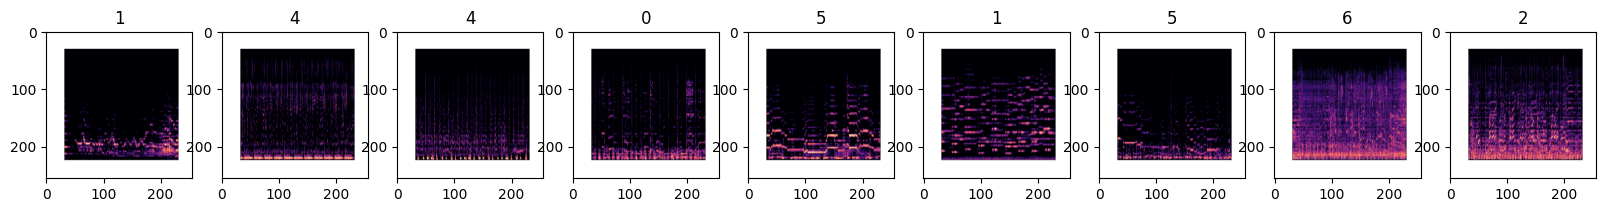

In [28]:
fig, ax = plt.subplots(ncols=9, figsize=(20,20))
for idx, img in enumerate(batch[0][:9]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Data Preprocessing

### Normalize images to between 0 and 1

### Convert labels to one-hot encoded vectors